# 2. Sentiment Analysis

This pipeline performs sentiment analysis on the scraped Reddit data. We use a SOTA sentiment model fine-tuned on Twitter data, available through HuggingFace.

First, adjust any constants if needed in the Setup section. Then, run the entire notebook.

## Setup

In [15]:
# Import necessary libraries
import json
import os
import logging
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [30]:
# Constants
INPUT_FILE = '../data/raw_reddit_data.json'
OUTPUT_FILE = '../data/sentiment_results.csv'
MODEL_NAME = 'cardiffnlp/twitter-roberta-base-sentiment'
BATCH_SIZE = 32  # For processing texts in batches
MAX_LENGTH = 512  # Maximum sequence length for the model

# Define label mapping, this is specific to the model used
LABEL_MAPPING = {
    'LABEL_0': 'Negative',
    'LABEL_1': 'Neutral',
    'LABEL_2': 'Positive'
}

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [17]:
# Initialize sentiment analysis pipeline with updated configuration
logging.info("Loading sentiment analysis model...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=DEVICE,
    batch_size=BATCH_SIZE,
    truncation=True,
    max_length=MAX_LENGTH
)

# Load data
logging.info(f"Loading data from {INPUT_FILE}...")
with open(INPUT_FILE, 'r') as f:
    reddit_data = json.load(f)

2024-11-02 23:52:11,311 - INFO - Loading sentiment analysis model...


2024-11-02 23:52:12,959 - INFO - Loading data from ../data/raw_reddit_data.json...


## Processing

In [18]:
# Prepare lists to store analysis results
users = []
texts = []
sentiment_labels = []
sentiment_scores = []

# Temporary lists to hold texts and corresponding user information for batch processing
batch_texts = []
batch_users = []

# Function to add data to the batch
def add_to_batch(user, text):
    batch_users.append(user)
    batch_texts.append(text)

In [19]:
# Process posts and comments
logging.info("Processing posts and comments...")
for post in tqdm(reddit_data, desc="Processing Posts"):
    # Check if the post contains the matching keyword
    if post.get('matching_keyword') == 'clinical trial':
        # Process post
        post_text = post.get('text', '')
        post_user = post.get('author', 'unknown')  # Assuming 'author' field contains the username
        add_to_batch(post_user, post_text)

        # Process comments
        for comment in post.get('comments', []):
            comment_text = comment.get('text', '')
            comment_user = comment.get('author', 'unknown')  # Assuming 'author' field
            add_to_batch(comment_user, comment_text)

        # If batch is full, perform sentiment analysis
        if len(batch_texts) >= BATCH_SIZE:
            try:
                sentiments = sentiment_pipeline(batch_texts)
                for user, text, sentiment in zip(batch_users, batch_texts, sentiments):
                    users.append(user)
                    texts.append(text)
                    sentiment_labels.append(sentiment['label'])
                    sentiment_scores.append(sentiment['score'])
            except Exception as e:
                logging.error(f"Error during batch sentiment analysis: {e}")
                # Optionally, handle individual texts here
            finally:
                # Clear the batch lists
                batch_texts = []
                batch_users = []

# Process any remaining texts in the batch
if batch_texts:
    try:
        sentiments = sentiment_pipeline(batch_texts)
        for user, text, sentiment in zip(batch_users, batch_texts, sentiments):
            users.append(user)
            texts.append(text)
            sentiment_labels.append(sentiment['label'])
            sentiment_scores.append(sentiment['score'])
    except Exception as e:
        logging.error(f"Error during final batch sentiment analysis: {e}")


2024-11-02 23:52:12,977 - INFO - Processing posts and comments...
Processing Posts: 100%|██████████| 332/332 [00:28<00:00, 11.51it/s]


## Post processing

In [31]:
# Create a DataFrame with the analysis results
df = pd.DataFrame({
    'user': users,
    'text': texts,
    'sentiment_label': sentiment_labels,
    'sentiment_score': sentiment_scores
})

# Map sentiment labels using the defined label mapping
df['sentiment_label'] = df['sentiment_label'].map(LABEL_MAPPING)


In [32]:
# Save the analysis data
logging.info(f"Saving analysis results to {OUTPUT_FILE}...")
df.to_csv(OUTPUT_FILE, index=False)

2024-11-02 23:57:50,848 - INFO - Saving analysis results to ../data/sentiment_results.csv...


In [38]:
df.head()

,user,text,sentiment_label,sentiment_score
0,jarchivistswag,"I’ve had chronic nerve pain and severe, bilateral paresthesia in both of my legs, for over a year and no doctors can figure it out. I’ve spoken with 6 neurologists about it who agree there’s no way it could be because of a few old, small herniated discs I have, but also can’t figure out what’s causing it. I can’t really sit down anymore because it makes my nerves so angry, and I really just feel shitty almost all the time. I’m on two medications for it, one that barely works and one that maybe has been helping but I just started it, so it’s difficult to say. \nI just don’t know what to do. I hate that I have to accept it but I don’t even know what’s happening. This is the rest of my life. Yes. I understand that. I feel terrible about it most days, but if I’m very strict with how I move and don’t sit or do things that make my nerves angry I can get by relatively not horrible feeling. But I don’t even know why it’s happening. I hate that I don’t know why it’s happening. I hate that maybe there could be a treatment, but I don’t know what it is, because I don’t even know what’s wrong with me. I hate that I will never be taken seriously about it by anyone because I don’t have an answer for it. I hate that I can never get on disability, because I have no diagnosis, even though just daily life kills me if I’m not living like an alien who barely steps out of line and I can’t work. I hate that my life is ruined. I’m just in such a weird place. It’s so hard to accept this when no one knows why it’s happening. My most recent neurology appointment said “we will do one more EMG and MRI of your lumbar plexus, and if that shows nothing your best bet might be clinical trials and seeing The Mayo Clinic.” What the fuck is my life? I have New York insurance. I can’t do shit anywhere else unless I’m so interesting to a researcher that they take me on pro-bono for the love of the game. What do I even do with myself? I feel so aimless. I just want to be comfortable again. Even a piece of my body is completely numb and it’s slowly spreading and I have no idea why. I constantly feel like my legs are being prickled by needles if I’m not careful and they always tingle. It’s just so distressing and overwhelming sometimes. I need to have more self restraint and stop trying to sit. I just miss my life. And myself. And how carefree everything was. I feel so fucking weird and I don’t know where I’m at. I just know my life is over, will continue to be over, and I will never be able to return to the type of carefree, physically able person I was before all of this garbage. And whenever I talk about it I’m just told that I’m depressing— that it’s depressing that I have no hope in ever getting better. But I won’t. I have to live like this and accept that it’s over. This is the only life I get. Wishing for a miracle that will never exist will get me nowhere. There is no cure. There is no way to even know what is wrong with me. But I really am just miserable a lot of the time. I got told by the person performing the repeat EMG that I was “a perfectly healthy 18 year old” based off my nerve impulses. I think I’m in hell. I’m trying my best. It never ends, though.",Negative,0.961714
1,hotheadnchickn,"Hey, I am so sorry you are dealing with this. It sounds like a lot of pain on a daily level as well as limitations, and right now, no help or diagnosis in sight. \n\nI also have an invisible issue that caused a sitting disability and it’s a really difficult and isolating limitation. I have other chronic illness/disability stuff but for me this aspect is the most limiting and the most hard to accommodate. And it’s a limit that is hard for people to wrap their head around. I have tried to explain when I am asking about spaces and potential accommodations and people offer me wheelchairs 🙄 So you think disability = wheelchair? Right after I said “sitting disability”???? \n\nI have a couple low key suggestions if 

2024-11-02 23:58:02,064 - INFO - Displaying sentiment score distribution...


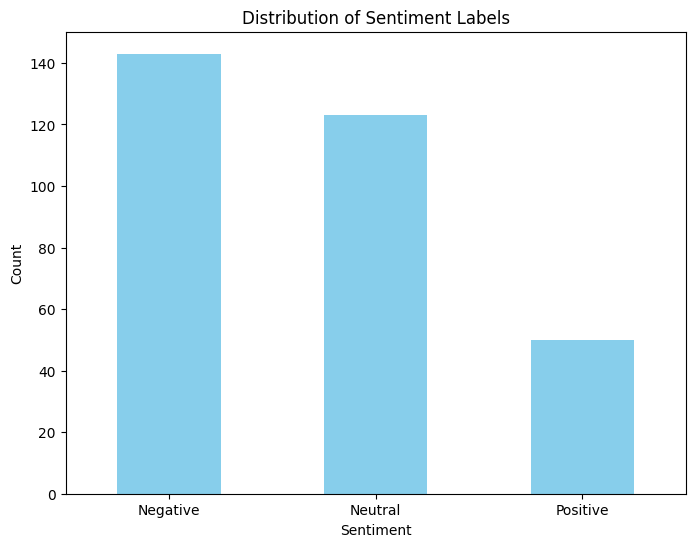

In [33]:
# Display distribution graph of the sentiment labels
logging.info("Displaying sentiment score distribution...")
plt.figure(figsize=(8, 6))
df['sentiment_label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()